In [2]:
import pandas as pd
%matplotlib inline

trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


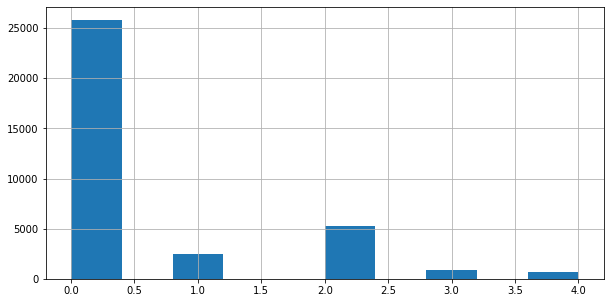

In [3]:
trainLabels['level'].hist(figsize = (10, 5))

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import cv2

In [5]:
base_image_dir = os.path.join('train/')
df = pd.read_csv(os.path.join('trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,0,train/2564_left.jpeg
1,2,train/41599_left.jpeg
2,0,train/25555_right.jpeg
3,0,train/28743_right.jpeg
4,2,train/4688_left.jpeg
5,0,train/38258_right.jpeg
6,0,train/1480_right.jpeg
7,0,train/20163_left.jpeg
8,0,train/40961_left.jpeg
9,0,train/2997_right.jpeg


In [6]:
df0=df.loc[df["level"]==0].sample(n=700)
df1=df.loc[df["level"]==1].sample(n=700)
df2=df.loc[df["level"]==2].sample(n=700)
df3=df.loc[df["level"]==3].sample(n=700)
df4=df.loc[df["level"]==4].sample(n=700)
df1=df1.append([df0,df2,df3]).reset_index(drop=True)

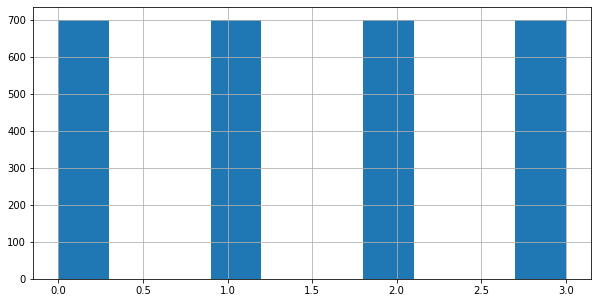

In [17]:
df1 = df1.sample(frac=1).reset_index(drop=True)
df1['level'].hist(figsize = (10, 5))

In [19]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df1,test_size=0.2)

In [20]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

3888 2592


In [53]:
bs = 50 #smaller batch size is better for training, but may take longer
sz=256

In [22]:
from fastai import *
from fastai.vision import *

In [23]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [24]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
#tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df1,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df1))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

UsageError: Line magic function `%inline` not found.


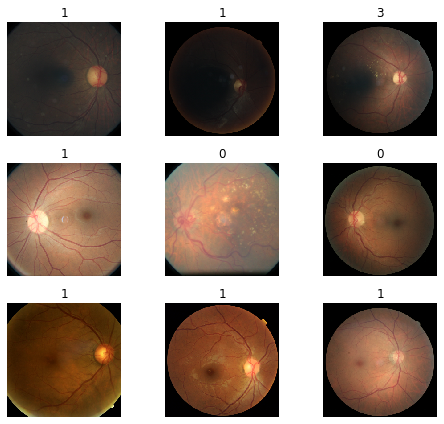

In [56]:
data.show_batch(rows=3, figsize=(7,6))
%inline matplotlib

In [57]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat,1), y, weights='quadratic'),device='cuda:0')

In [58]:
import torchvision
f_score = partial(fbeta, thresh=0.2, beta = 1)
learn = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])

In [59]:

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


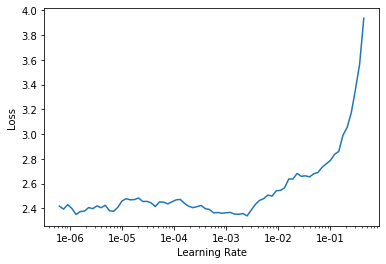

In [45]:
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(4,max_lr=1e-025)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,2.394233,1.871460,0.237077,-0.025273,12:59
1,2.402583,1.849955,0.237077,-0.026995,11:25
2,2.407643,1.863552,0.242424,-0.021407,10:41
3,2.365119,1.846514,0.238859,-0.015822,10:40


In [62]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

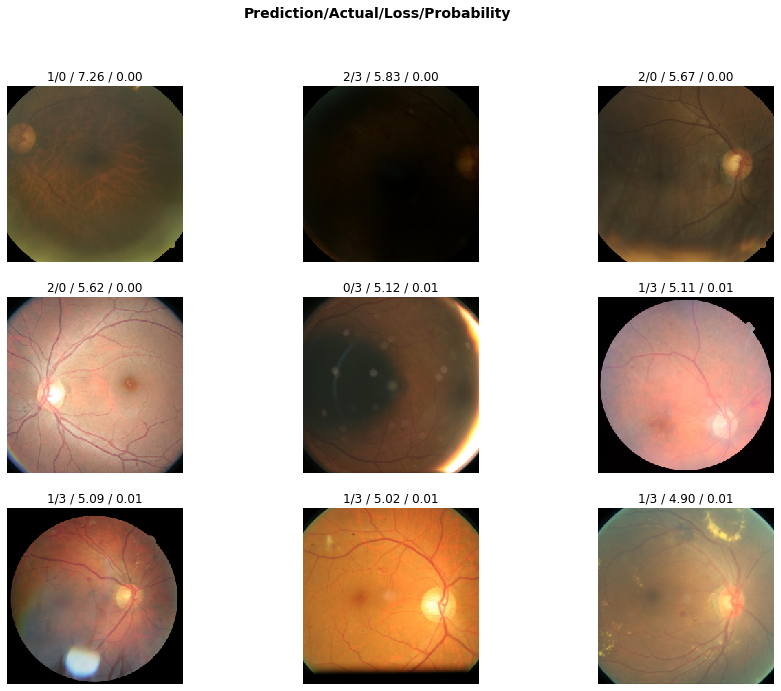

In [63]:
interp.plot_top_losses(9, figsize=(15,11))

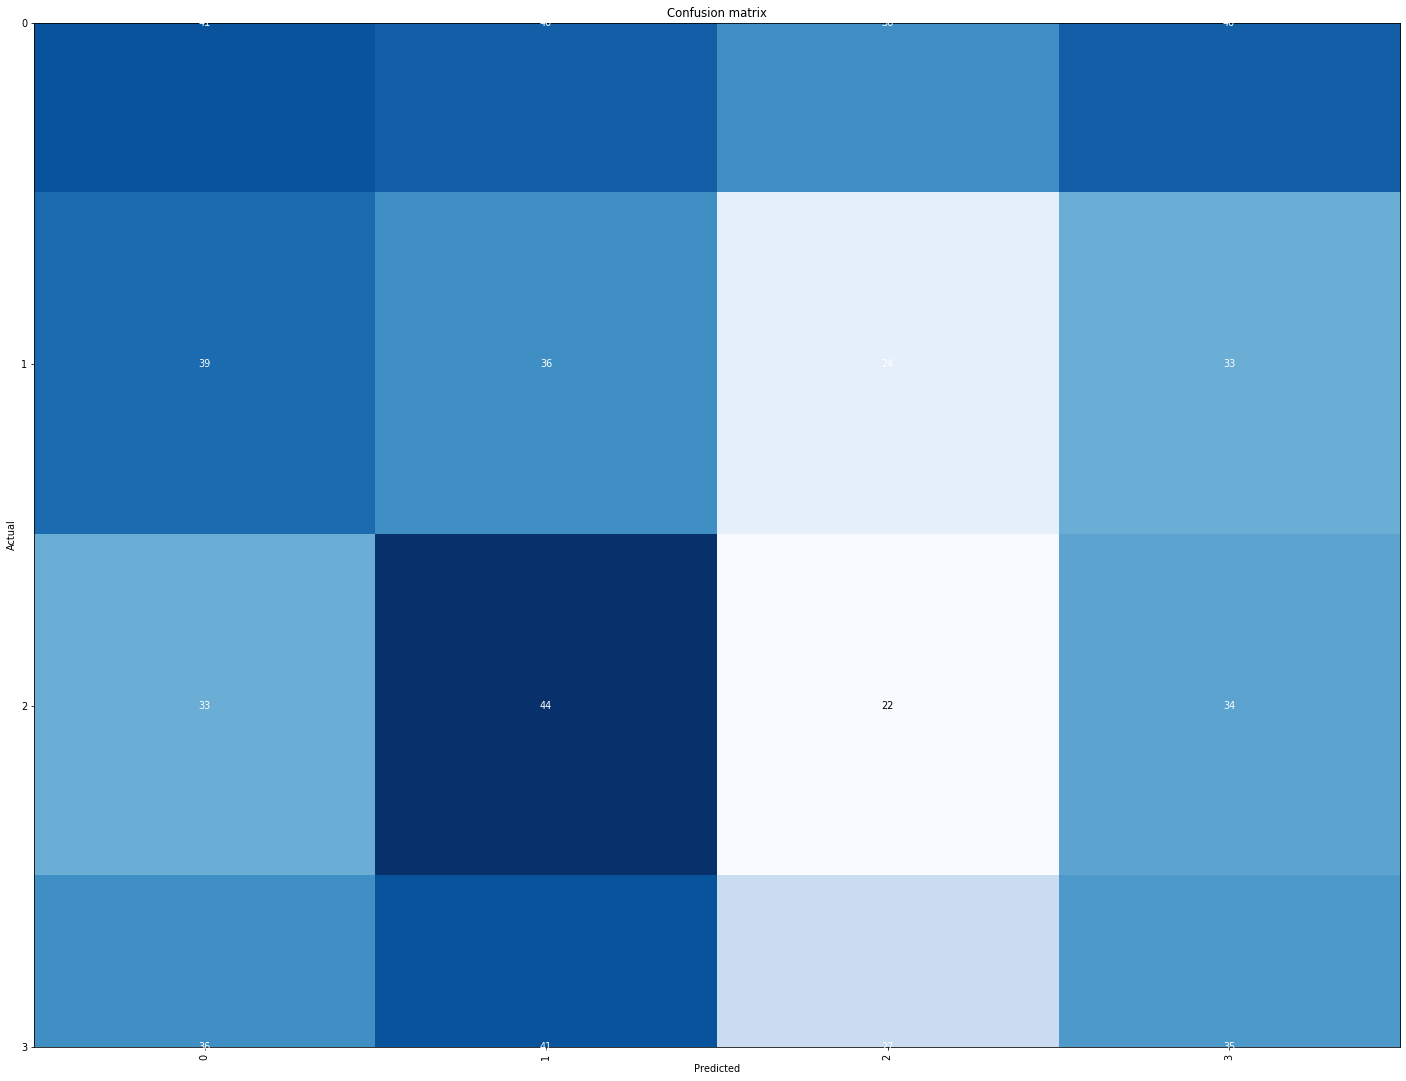

In [71]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=70)